# Use graphx to solve real world problems



In [4]:
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import os
from pyspark.sql import Row
from graphframes import GraphFrame
from pathlib import Path

In [16]:
def buildEdgesLabels(InGraph:GraphFrame):
    edgeLabels = {}
    # edgeList is a list of spark dataframe rows
    edgeList = InGraph.edges.collect()
    for edgeItem in edgeList:
        edgeLabels[(edgeItem["src"], edgeItem["dst"])]=edgeItem["type"]
    return edgeLabels

def drawGraph(InGraph:GraphFrame):
    nxGraph = nx.Graph()
    for edge in InGraph.edges.collect():
        nxGraph.add_edge(edge["src"], edge["dst"])
    
    # Define layout
    pos = nx.spring_layout(nxGraph, seed=42)
    
    # Draw nodes and edges
    nx.draw(nxGraph, pos, with_labels=True, node_size=400, node_color='lightblue', font_size=10, font_color='black')
    nx.draw_networkx_edge_labels(nxGraph, pos, edge_labels=buildEdgesLabels(InGraph))
    
    plt.show()

In [3]:

local=True
if local:
    spark = SparkSession.builder\
        .master("local[4]")\
        .appName("GraphX")\
        .config("spark.executor.memory", "4g")\
        .config('spark.jars.packages','graphframes:graphframes:0.8.2-spark3.2-s_2.12') \
        .getOrCreate()
else:
    spark = SparkSession.builder\
        .master("k8s://https://kubernetes.default.svc:443")\
        .appName("GraphX")\
        .config("spark.kubernetes.container.image", "inseefrlab/jupyter-datascience:master")\
        .config("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT'])\
        .config('spark.jars.packages','graphframes:graphframes:0.8.2-spark3.2-s_2.12') \
        .config("spark.executor.instances", "4")\
        .config("spark.executor.memory","2g")\
        .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])\
        .getOrCreate()

# make the large dataframe show pretty
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

23/10/05 11:13:55 WARN Utils: Your hostname, pengfei-Virtual-Machine resolves to a loopback address: 127.0.1.1; using 10.50.2.80 instead (on interface eth0)
23/10/05 11:13:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/pengfei/opt/spark-3.3.0/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/pengfei/.ivy2/cache
The jars for the packages stored in: /home/pengfei/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0231815b-abad-45bc-ab43-e0d946bf6edd;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 530ms :: artifacts dl 14ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	------------------------------

23/10/05 11:13:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [11]:
data_path = Path("/home/pengfei/git/PySparkCommonFunc/data")
doc_path = data_path / 'doctors.csv'
patient_path = data_path / 'patients.csv'
relation_path = data_path / 'doc_patient_relation.csv'

In [8]:
doc_df = spark.read.csv(str(doc_path),header=True,inferSchema=True)
doc_df.show()

+---+--------------+--------------------+---+
| id|          name|               title|age|
+---+--------------+--------------------+---+
| D1|Carter_Derrick|             dentist| 50|
| D2|   May_Derrick|        pediatrician| 26|
| D3|    Mills_Jeff|           ophthalmo| 80|
| D4|   Hood_Robert|general_practitioner| 65|
| D5|    Banks_Mike|             surgeon| 43|
| D6|      Berg_Tim|general_practitioner| 28|
| D7|    Page_Allan|general_practitioner| 16|
| D8|Carter_Derrick|             dentist| 50|
+---+--------------+--------------------+---+


In [10]:
patient_df = spark.read.csv(str(patient_path),header=True,inferSchema=True)
patient_df.show()

+---+-----------+-------+---+
| id|       name|  title|age|
+---+-----------+-------+---+
| P1|    Foo_Bar|patient| 26|
| P2|May_Derrick|patient| 26|
| P3| Mills_Jeff|patient| 80|
| P4|Hood_Robert|patient| 65|
| P5| Banks_Mike|patient| 93|
| P6|   Berg_Tim|patient| 28|
| P7| Page_Allan|patient| 16|
| P8|    Foo_Bar|patient| 26|
| P9|May_Derrick|patient| 26|
|P10| Mills_Jeff|patient| 80|
|P11|Hood_Robert|patient| 65|
|P12| Banks_Mike|patient| 93|
|P13|   Berg_Tim|patient| 28|
|P14| Page_Allan|patient| 16|
+---+-----------+-------+---+


In [13]:
relation_df = spark.read.csv(str(relation_path),header=True,inferSchema=True)
relation_df.show()

+---+---+-----+
|src|dst| type|
+---+---+-----+
| D2|P14|treat|
| D3| P1|treat|
| D1| P3|treat|
| D4| P1|treat|
| D4| P2|treat|
| D4| P3|treat|
| D4| P4|treat|
| D6| P5|treat|
| D6| P6|treat|
| D6| P7|treat|
| D6| P8|treat|
| D7| P9|treat|
| D7|P10|treat|
| D7|P11|treat|
| D7|P12|treat|
| D5|P10|treat|
| D5|P12|treat|
| D1| P2|treat|
| D1| P7|treat|
| D1| P8|treat|
+---+---+-----+


In [14]:
edges_df = patient_df.union(doc_df)

graph = GraphFrame(edges_df,relation_df)

/home/pengfei/.cache/pypoetry/virtualenvs/sparkcommonfunc-jby-k8HJ-py3.8/lib/python3.8/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


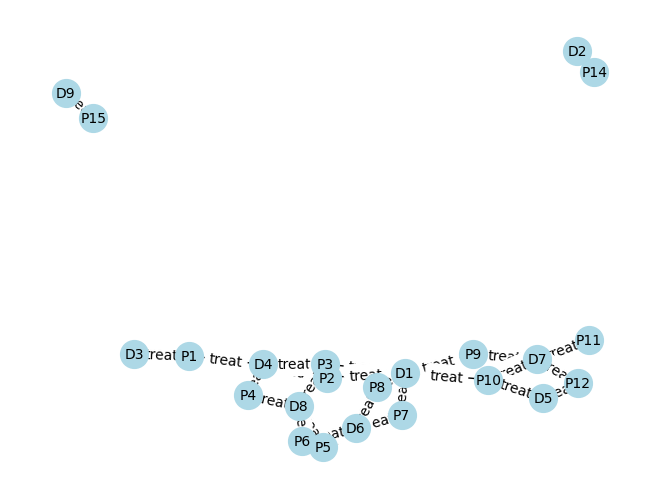

In [17]:
drawGraph(graph)